In [18]:
import tensorflow as tf

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### 1.6 基本的训练循环
#在前面的教程里，您已经了解了tensors, variables, gradient tape, 和modules。在这篇教程，您将把它们放在一起训练模型。
#此外，TensorFlow 还包括 tf.Keras API，这是一种高级神经网络 API，可提供有用的抽象来减少样板。但是，在本指南中，您将使用基本类。


In [19]:
### 1.6.1 解决机器学习问题

#解决一个机器学习问题通常包含以下步骤：
#   获得训练数据。
#   定义模型。
#   定义损失函数。
#   遍历训练数据，从目标值计算损失。
#   计算该损失的梯度，并使用optimizer调整变量以适合数据。
#   计算结果。

#为了便于说明，在本指南中，您将开发一个简单的线性模型,f(x) = x*W +b, 其中包含两个变量: W(权重) 和 b(偏差)。
#这是最基本的机器学习问题：给定x 和 y，尝试通过简单的线性回归来找到直线的斜率和偏移量。

In [20]:
### 1.6.2 数据
#下面是通过将高斯（正态）噪声添加到直线上的点而合成的一些数据。
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2,2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

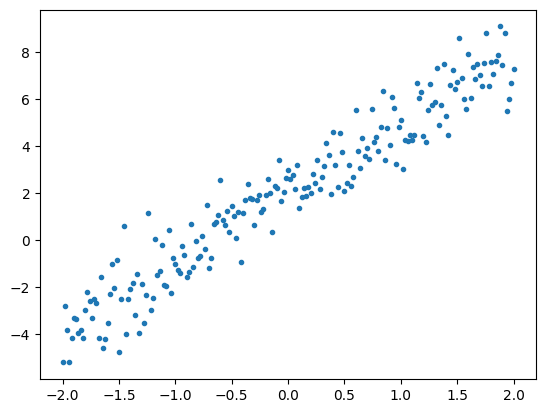

In [21]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

In [22]:
### 1.6.3 定义模型

#使用 tf.Variable 代表模型中的所有权重。tf.Variable 能够存储值，并根据需要以张量形式提供它。详情请见 variable guide。
#使用 tf.Module 封装变量和计算。您可以使用任何Python对象，但是通过这种方式可以轻松保存它。

#这里，您可以定义 w 和 b 为变量。
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

#初始变量在此处以固定方式设置，但 Keras 提供了您可以与或不与 Keras 其他部分一起使用的许多初始值设定项。



Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


In [23]:
## 1.定义损失函数
#损失函数衡量给定输入的模型输出与目标输出的匹配程度。目的是在训练过程中尽量减少这种差异。定义标准的L2损失，也称为“均方误差”:
def loss(target_y,pred_y):
    return tf.reduce_mean(tf.square(target_y - pred_y))


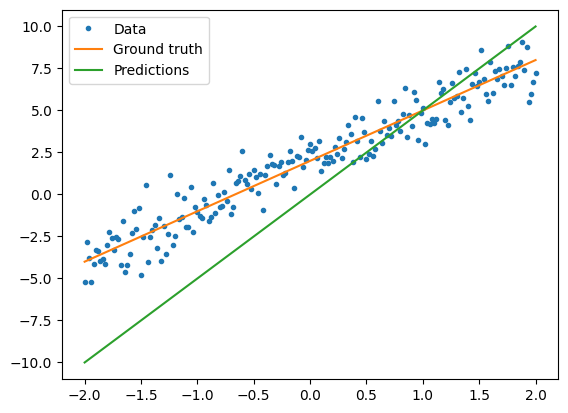

Current loss: 10.713898


In [24]:
#在训练模型之前，您可以可视化损失值。使用红色绘制模型的预测值，使用蓝色绘制训练数据。
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

In [28]:
## 2. 定义训练循环

#训练循环按顺序重复执行以下任务：
#   发送一批输入值，通过模型生成输出值
#   通过比较输出值与输出（标签），来计算损失值
#   使用梯度带(GradientTape)找到梯度值
#   使用这些梯度优化变量

#这个例子中，您可以使用 gradient descent训练数据。
#tf.keras.optimizers中有许多梯度下降的变量。但是本着搭建的第一原则，您将在这里 借助
#tf.GradientTape的自动微分和tf.assign_sub的递减值（结合了tf.assign和tf.sub）自己实现基本数学：

def train(model, x, y, learning_rate):

    with tf.GradientTape() as t:
        # Trainable variables are automatically tracked by GradientTape
        current_loss = loss(y, model(x))

    #Use GradientTape to calculate the gradients with respect to W and b   
    dw, db = t.gradient(current_loss, [model.w, model.b])

    #Subtract the gradient scaled by the learning rate
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)



In [29]:
#要查看训练，您可以通过训练循环发送同一批次的 x 和 y，并观察 W 和 b 如何变化。
model = MyModel()

## Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

#Define a train loop
def report(model, loss):
    return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"

def training_loop(model, x, y):
    for epoch in epochs:
        # Update the model with the single giant batch
        train(model, x, y, learning_rate=0.1)

        # Track this before I update
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        current_loss = loss(y, model(x))

        print(f"Epoch {epoch:2d}:")
        print("    ", report(model, current_loss))


In [30]:
##进行训练

current_loss = loss(y,model(x))
print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)

Starting:
     W = 5.00, b = 0.00, loss=10.71390
Epoch  0:
     W = 4.45, b = 0.40, loss=6.59036
Epoch  1:
     W = 4.04, b = 0.72, loss=4.23416
Epoch  2:
     W = 3.74, b = 0.98, loss=2.87721
Epoch  3:
     W = 3.53, b = 1.19, loss=2.08938
Epoch  4:
     W = 3.37, b = 1.35, loss=1.62821
Epoch  5:
     W = 3.25, b = 1.48, loss=1.35605
Epoch  6:
     W = 3.17, b = 1.59, loss=1.19413
Epoch  7:
     W = 3.11, b = 1.67, loss=1.09705
Epoch  8:
     W = 3.06, b = 1.74, loss=1.03842
Epoch  9:
     W = 3.03, b = 1.80, loss=1.00276


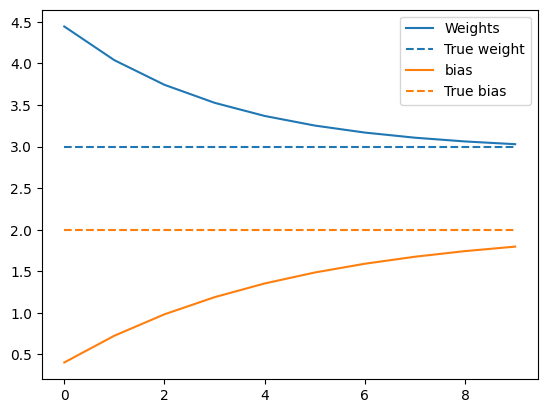

In [31]:
#下面是权重随时间的演变：
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

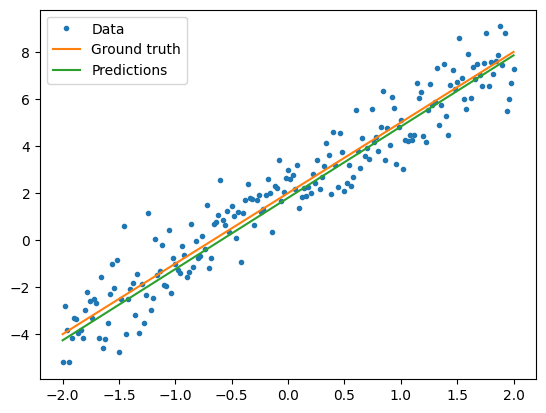

Current loss: 1.002757


In [32]:
#呈现训练的模型的性能
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

In [34]:
### 1.6.4 使用Keras完成相同的解决方案

#将上面的代码与Keras中的等效代码进行对比很有用。
#如果您将tf.keras.Model子类化，则定义模型与其看起来完全相同。请记住，Keras模型最终从模块继承。
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("__Checkpoint/keras/my_checkpoint")

Epoch  0:
     W = 4.45, b = 0.40, loss=6.59036
Epoch  1:
     W = 4.04, b = 0.72, loss=4.23416
Epoch  2:
     W = 3.74, b = 0.98, loss=2.87721
Epoch  3:
     W = 3.53, b = 1.19, loss=2.08938
Epoch  4:
     W = 3.37, b = 1.35, loss=1.62821
Epoch  5:
     W = 3.25, b = 1.48, loss=1.35605
Epoch  6:
     W = 3.17, b = 1.59, loss=1.19413
Epoch  7:
     W = 3.11, b = 1.67, loss=1.09705
Epoch  8:
     W = 3.06, b = 1.74, loss=1.03842
Epoch  9:
     W = 3.03, b = 1.80, loss=1.00276


In [35]:
#您可以使用Keras的内置功能作为捷径，而不必在每次创建模型时都编写新的训练循环。当您不想编写或调试Python训练循环时，这很有用。
#如果您使用Keras，您将会需要使用 model.compile() 去设置参数, 使用model.fit() 进行训练。借助Keras实现L2损失和梯度下降需要的代码量更少，
#  就像一个捷径。Keras损失和优化器也可以在这些便利功能之外使用，而前面的示例也可以使用它们。
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

In [36]:
#Kerasfit期望批处理数据或完整的数据集作为NumPy数组。 NumPy数组分为多个批次，默认批次大小为32。

#这一案例中，为了匹配手写训练循环，您应该以大小为1000的单批次传递x。
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000) #请注意，Keras会在训练后而不是之前打印出损失，
                                                  #因此第一次损失会显得较低。否则，这表明本质上相同的训练效果。

201
Epoch 1/10

1/1 [==============================] - 1s 983ms/step - loss: 10.7139
Epoch 2/10
1/1 [==============================] - 0s 17ms/step - loss: 6.5904
Epoch 3/10
1/1 [==============================] - 0s 16ms/step - loss: 4.2342
Epoch 4/10
1/1 [==============================] - 0s 17ms/step - loss: 2.8772
Epoch 5/10
1/1 [==============================] - 0s 16ms/step - loss: 2.0894
Epoch 6/10
1/1 [==============================] - 0s 17ms/step - loss: 1.6282
Epoch 7/10
1/1 [==============================] - 0s 17ms/step - loss: 1.3560
Epoch 8/10
1/1 [==============================] - 0s 18ms/step - loss: 1.1941
Epoch 9/10
1/1 [==============================] - 0s 18ms/step - loss: 1.0970
Epoch 10/10
1/1 [==============================] - 0s 17ms/step - loss: 1.0384


In [ ]:
### 总结

#虽然用keras可以方便的创建并训练模型，但是了解底层实现原理也很重要。
#有时候我们需要了解底层api，例如修改使用tf1实现的模型训练的代码。